<a href="https://colab.research.google.com/github/InnaK342/nn2022/blob/main/Lab5/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторна робота 5
##Convolutional Neural Networks and Computer Vision with TensorFlow
##Завдання
1. На основі документу вирішити завдання класифікації зображень їжі для 3 класів з набору даних food101
2. Індекси класів визначити індивідуально за залежностями: i1=7,i2=37,i3=67 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.
3. Результати оформити у вигляді файлу з кодом для моделювання та візуалізації у форматі .ipynb


##Завантажимо набір даних

In [23]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-04-24 10:23:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  78.7MB/s    in 20s     

2022-04-24 10:23:33 (77.5 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



##Відберемо класи за варіантом для тренування

In [24]:
import pathlib
import numpy as np
import os

#Кількість зображень в файлі
data_dir_train = pathlib.Path("101_food_classes_10_percent/train/") 
data_dir_test = pathlib.Path("101_food_classes_10_percent/test/")
num_food_images_train = len(os.listdir(data_dir_train))
print('Count of images are in a file:', num_food_images_train)

#Відберемо 3 задані варіанти
arr_index = [7,37,67]
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
new_class_names = [class_names[arr_index[0]], class_names[arr_index[1]],class_names[arr_index[2]]]
print('Our classes:', new_class_names)

Count of images are in a file: 101
Our classes: ['bibimbap', 'filet_mignon', 'omelette']


##Залишимо в файлах тільки наші класи

In [25]:
from pathlib import Path
import shutil

#Видалимо всі класи, окрім заданих
for name in class_names:
  if name != new_class_names[0] and name != new_class_names[1] and name != new_class_names[2]:
    dirpath = Path(data_dir_train) / name
    dirpath_test = Path(data_dir_test) / name
    if dirpath_test.exists() and dirpath_test.is_dir():
        shutil.rmtree(dirpath)
        shutil.rmtree(dirpath_test)
print('Test:', os.listdir(data_dir_test))
print('Train:', os.listdir(data_dir_train))

Test: ['bibimbap', 'omelette', 'filet_mignon']
Train: ['bibimbap', 'omelette', 'filet_mignon']


##Відображення даних

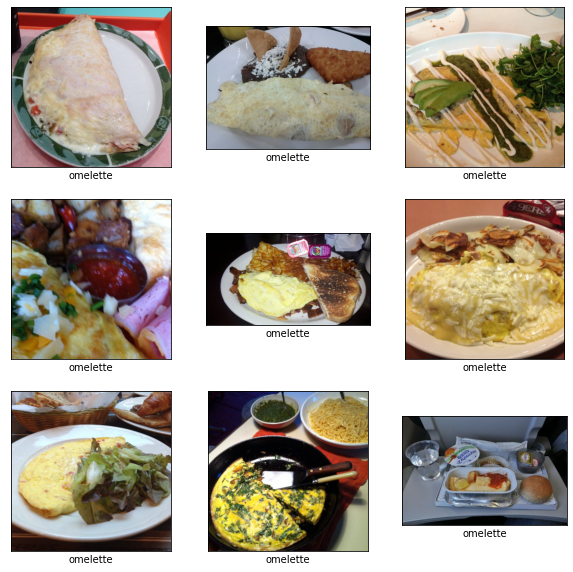

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    target_folder = '101_food_classes_10_percent/train/'+'omelette'
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.xlabel('omelette')
plt.show()

##Нормування та перетворення файлів в дані

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "101_food_classes_10_percent/test/"
test_dir = "101_food_classes_10_percent/train/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')


Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


##Підготовка зображень до навчання

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.


##Навчання мережі

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model = model.fit(train_data_augmented,
                          epochs=30,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/30
24/24 [==============================] - 48s 2s/step - loss: 1.0300 - accuracy: 0.4720 - val_loss: 0.8757 - val_accuracy: 0.6622
Epoch 2/30
24/24 [==============================] - 47s 2s/step - loss: 0.7580 - accuracy: 0.6707 - val_loss: 0.8992 - val_accuracy: 0.6756
Epoch 3/30
24/24 [==============================] - 47s 2s/step - loss: 0.7562 - accuracy: 0.6987 - val_loss: 0.8977 - val_accuracy: 0.7156
Epoch 4/30
24/24 [==============================] - 47s 2s/step - loss: 0.6906 - accuracy: 0.7013 - val_loss: 0.8904 - val_accuracy: 0.6533
Epoch 5/30
24/24 [==============================] - 47s 2s/step - loss: 0.7080 - accuracy: 0.6987 - val_loss: 0.7898 - val_accuracy: 0.7022
Epoch 6/30
24/24 [==============================] - 47s 2s/step - loss: 0.6500 - accuracy: 0.7293 - val_loss: 0.8935 - val_accuracy: 0.7333
Epoch 7/30
24/24 [==============================] - 48s 2s/step - loss: 0.6858 - accuracy: 0.7187 - val_loss: 0.8290 - val_accuracy: 0.7156
Epoch 8/30
24/24 [==

##Функції для виведення графіків точності навчання

In [31]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

##Виведення графіків

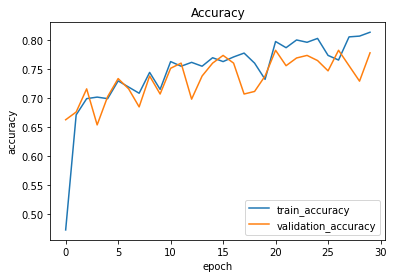

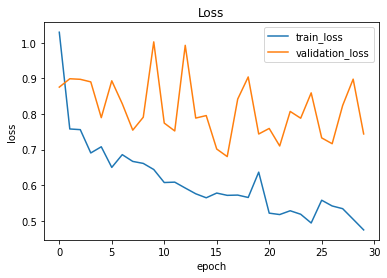

In [34]:
plot_accuracy(history_model,'Accuracy')
plot_loss(history_model,'Loss')

##Функція для прогнозування даних

In [41]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    new_class_names.sort()
    pred_value = new_class_names[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

##Завантажимо зображення для перевірки

In [38]:
!wget -O omelette.jpg https://downshiftology.com/wp-content/uploads/2021/12/How-to-Make-an-Omelette-main-1-500x500.jpg
!wget -O bibimbap.jpg https://www.recipetineats.com/wp-content/uploads/2019/05/Bibimbap_3.jpg
!wget -O filet_mignon.jpg https://www.cookingclassy.com/wp-content/uploads/2020/12/filet-mignon-23.jpg


--2022-04-24 11:50:20--  https://downshiftology.com/wp-content/uploads/2021/12/How-to-Make-an-Omelette-main-1-500x500.jpg
Resolving downshiftology.com (downshiftology.com)... 104.19.155.92, 104.19.154.92, 2606:4700::6813:9a5c, ...
Connecting to downshiftology.com (downshiftology.com)|104.19.155.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40751 (40K) [image/jpeg]
Saving to: ‘omelette.jpg’

omelette.jpg        100%[===================>]  39.80K  --.-KB/s    in 0s      

2022-04-24 11:50:20 (115 MB/s) - ‘omelette.jpg’ saved [40751/40751]

--2022-04-24 11:50:20--  https://www.recipetineats.com/wp-content/uploads/2019/05/Bibimbap_3.jpg
Resolving www.recipetineats.com (www.recipetineats.com)... 192.0.66.112
Connecting to www.recipetineats.com (www.recipetineats.com)|192.0.66.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91715 (90K) [image/jpeg]
Saving to: ‘bibimbap.jpg’

bibimbap.jpg        100%[===================>]  89.57K  -

##Перевірка

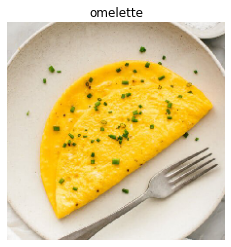

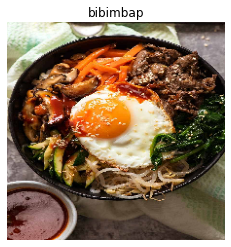

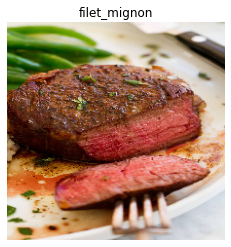

In [44]:
images = []
images.append('omelette.jpg')
images.append('bibimbap.jpg')
images.append('filet_mignon.jpg')
predict_class(model, images, True)

##Висновок:
В ході лабораторної роботи я вирішила завдання класифікації зображень їжі для 3 заданих класів.